In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pathlib import Path
from scipy import stats
from scipy.optimize import curve_fit, minimize

In [2]:
data_location = Path(r'./biological_COT_Data.ods')

xlsx = pd.ExcelFile(data_location, engine='odf')

In [3]:
xlsx.sheet_names

['Videler and Nolet', 'Videler_GCOTLW', 'Schmidt-Nielsen', 'Bale_CE']

In [4]:
main_df = xlsx.parse(xlsx.sheet_names[0])

modes = ['U', 'H', 'F', 'P', 'J']

data_dfs = []

for mode in modes:
    data_dfs.append(main_df[main_df['Mode']== mode])

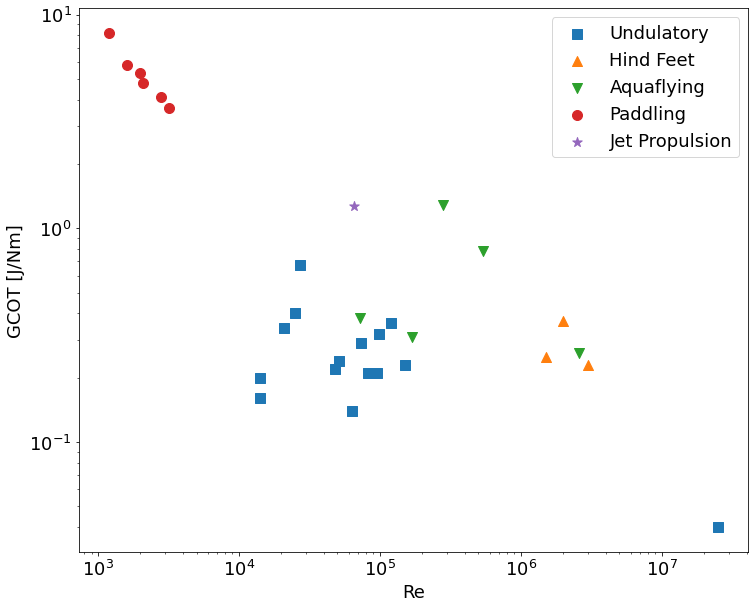

In [5]:
plt.rcParams.update({'font.size':18, 'lines.markersize':10})

fig1, ax1 = plt.subplots(figsize=(12, 10), facecolor='w')
markers = ['s', '^', 'v', 'o', '*']

legend_modes = ['Undulatory', 'Hind Feet', 'Aquaflying', 'Paddling', 'Jet Propulsion']
for i, df in enumerate(data_dfs):
    ax1.scatter(df['Re'], df['GCOT'], marker=markers[i], label=legend_modes[i])

ax1.set_ylabel('GCOT [J/Nm]')
ax1.set_xlabel('Re')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.legend()
#fig1.savefig('videler_GCOT_Re.pdf', facecolor='w', dpi=300, bbox_inches='tight')

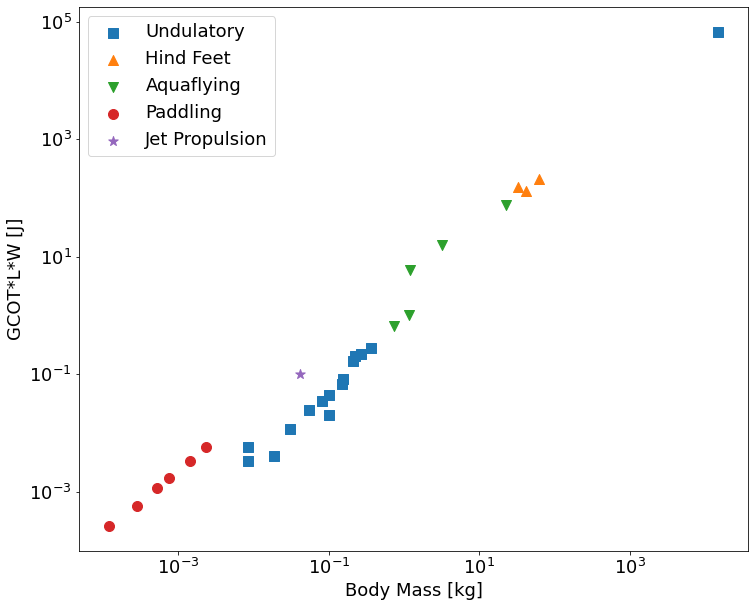

In [6]:
fig2, ax2 = plt.subplots(figsize=(12, 10), facecolor='w')
markers = ['s', '^', 'v', 'o', '*']

legend_modes = ['Undulatory', 'Hind Feet', 'Aquaflying', 'Paddling', 'Jet Propulsion']
for i, df in enumerate(data_dfs):
    glw = np.multiply(np.multiply(df['GCOT'].values, df['L [m]'].values), df['M [kg]'].values*9.81)
    ax2.scatter(df['M [kg]'], glw, marker=markers[i], label=legend_modes[i])

ax2.set_ylabel('GCOT*L*W [J]')
ax2.set_xlabel('Body Mass [kg]')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.legend()
#fig2.savefig('videler_GCOTLW_Mass.pdf', facecolor='w', dpi=300, bbox_inches='tight')

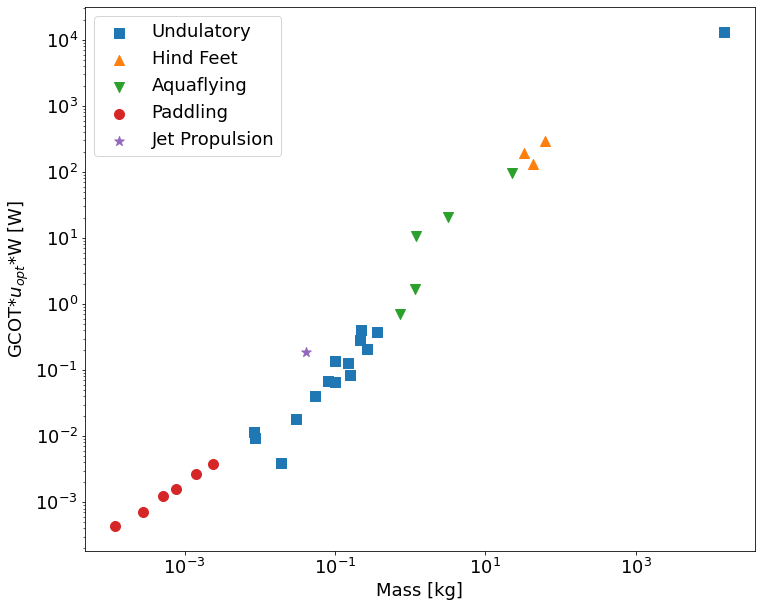

In [7]:
fig3, ax3 = plt.subplots(figsize=(12, 10), facecolor='w')
markers = ['s', '^', 'v', 'o', '*']

legend_modes = ['Undulatory', 'Hind Feet', 'Aquaflying', 'Paddling', 'Jet Propulsion']
for i, df in enumerate(data_dfs):
    glw = np.multiply(np.multiply(df['GCOT'].values, df['u_opt'].values), df['M [kg]'].values*9.81)
    ax3.scatter(df['M [kg]'], glw, marker=markers[i], label=legend_modes[i])

ax3.set_ylabel('GCOT*$u_{opt}$*W [W]')
ax3.set_xlabel('Mass [kg]')
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.legend()
#fig3.savefig('videler_GCOTuW_Mass.pdf', facecolor='w', dpi=300, bbox_inches='tight')

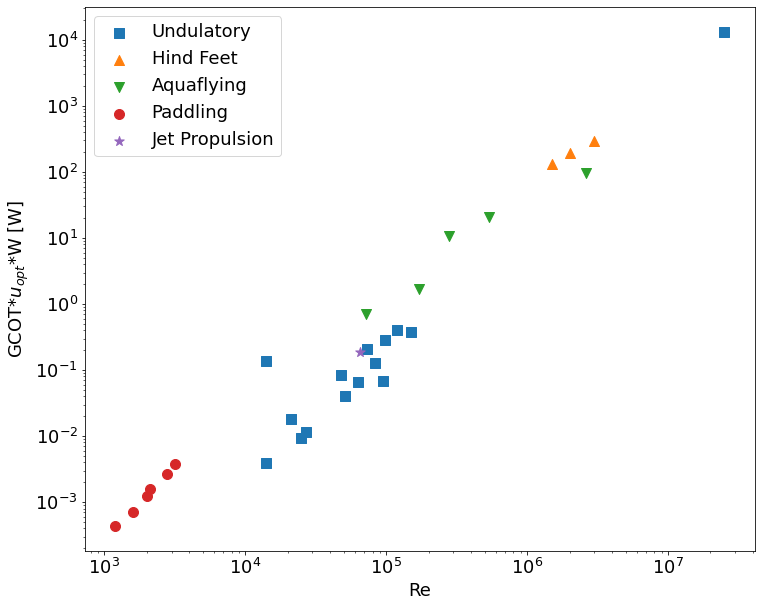

In [8]:
fig4, ax4 = plt.subplots(figsize=(12, 10), facecolor='w')
markers = ['s', '^', 'v', 'o', '*']

legend_modes = ['Undulatory', 'Hind Feet', 'Aquaflying', 'Paddling', 'Jet Propulsion']
for i, df in enumerate(data_dfs):
    glw = np.multiply(np.multiply(df['GCOT'].values, df['u_opt'].values), df['M [kg]'].values*9.81)
    ax4.scatter(df['Re'], glw, marker=markers[i], label=legend_modes[i])

ax4.set_ylabel('GCOT*$u_{opt}$*W [W]')
ax4.set_xlabel('Re')
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.legend()
#fig4.savefig('videler_GCOTuW_Re.pdf', facecolor='w', dpi=300, bbox_inches='tight')

In [9]:
# returns power law
def power_law(xData, a, b):
        return a * xData ** b

def linear(xData, a, b):
        return a + b*xData

# method to fit data
def fit_data(xData, yData, ci):

    # Convert to percentile point of normal distribution
    pp = (1. + ci) / 2.

    # convert to number os standard deviations
    nstd = stats.norm.ppf(pp)

    # use the curve fit scipy function
    popt, pcov = curve_fit(power_law, xData, yData, p0=[1, 1], maxfev=5000)
    #popt, pcov = curve_fit(linear, xData, yData, p0=[1, 1])

    # standard deviation of parameters.  1 sigma error.
    perr = np.sqrt(np.diag(pcov))

    # Add nstd standard deviations to parameters to obtain the confidence
    # interval.
    popt_up = popt + nstd * perr
    popt_dwn = popt - nstd * perr

    # find the residuals between data and fit
    residuals = yData - power_law(xData, *popt)

    ss_res = np.sum(residuals**2)
    ss_total = np.sum((yData-np.mean(yData))**2)
    
    r_squared = 1 - (ss_res/ss_total)

    return popt, popt_up, popt_dwn, r_squared

In [10]:
Re_df = main_df.sort_values(by=['Re'])
Re_turtles = Re_df[Re_df['Mode'].isin(['U'])]
Re_submerged = Re_df[Re_df['Mode'].isin(['U', 'H', 'F', 'J'])]

popt_all, popt_up_all, popt_dwn_all, r_squared_all = fit_data(np.log(Re_df['Re'].values), np.log(Re_df['GCOTuW'].values), 0.97)

popt_turtles, popt_up_turtles, popt_dwn_turtles, r_squared_turtles = fit_data(np.log(Re_turtles['Re'].values), np.log(Re_turtles['GCOTuW'].values), 0.97)

In [11]:
Re_df = main_df.sort_values(by=['Re'])
Re_turtles = Re_df[Re_df['Mode'].isin(['P'])]
Re_submerged = Re_df[Re_df['Mode'].isin(['U', 'H', 'F', 'J'])]

popt_all, popt_up_all, popt_dwn_all, r_squared_all = fit_data(Re_df['M [kg]'].values, Re_df['Re'].values, 0.97)

popt_turtles, popt_up_turtles, popt_dwn_turtles, r_squared_turtles = fit_data(Re_turtles['M [kg]'].values, Re_turtles['Re'].values, 0.97)

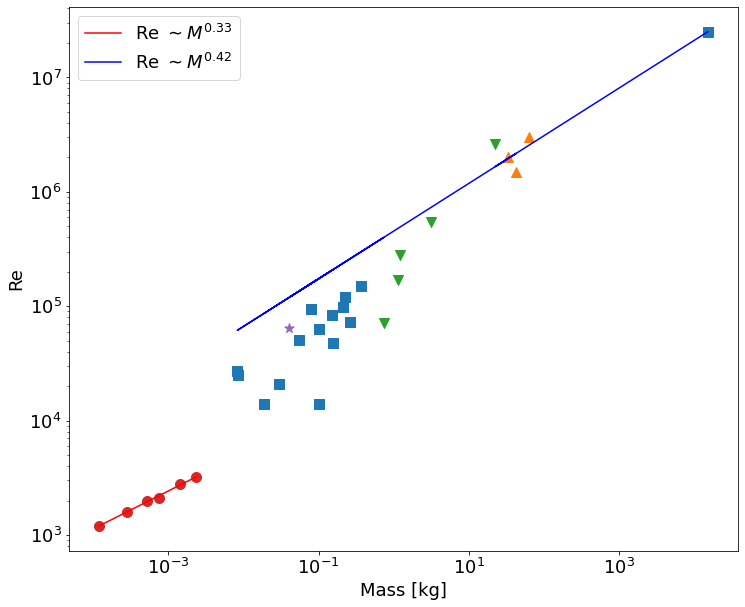

In [12]:
fig5, ax5 = plt.subplots(figsize=(12, 10), facecolor='w')
markers = ['s', '^', 'v', 'o', '*']

legend_modes = ['Undulatory', 'Hind Feet', 'Aquaflying', 'Paddling', 'Jet Propulsion']
for i, df in enumerate(data_dfs):
    ax5.scatter(df['M [kg]'], df['Re'], marker=markers[i])

ax5.plot(Re_turtles['M [kg]'], power_law(Re_turtles['M [kg]'], *popt_turtles), 'r-', label='Re $\\sim M^{' + str(np.round(popt_turtles[1], 2)) + '}$')
ax5.plot(Re_submerged['M [kg]'], power_law(Re_submerged['M [kg]'], *popt_all), 'b-', label='Re $\\sim M^{' + str(np.round(popt_all[1], 2)) + '}$')
ax5.set_ylabel('Re')
ax5.set_xlabel('Mass [kg]')
ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.legend()
#fig5.savefig('videler_Re_Mass.pdf', facecolor='w', dpi=300, bbox_inches='tight')

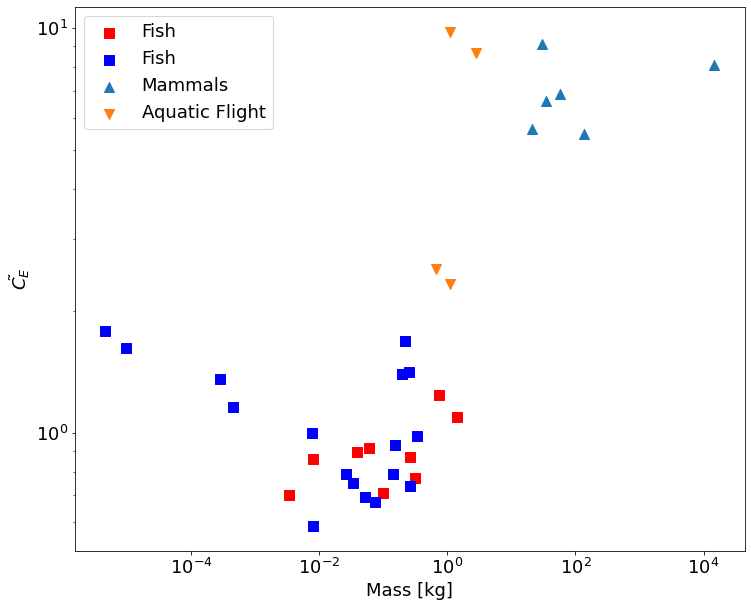

In [22]:
bale_df = xlsx.parse(xlsx.sheet_names[-1])
fig6, ax6 = plt.subplots(figsize=(12, 10), facecolor='w')
markers = ['s', '^', 'v', 'o', '*']

fish_1 = bale_df[(bale_df['Type']=='Fish') & (bale_df['Reference']==1)]
fish_2 = bale_df[(bale_df['Type']=='Fish') & (bale_df['Reference']==2)]
mammal = bale_df[bale_df['Type']=='Mammal']
aqFlight = bale_df[bale_df['Type']=='Aquatic Flight']

ax6.scatter(fish_1['Mass'], fish_1['Ce'], marker='s', color='red', label='Fish')
ax6.scatter(fish_2['Mass'], fish_2['Ce'], marker='s', color='blue', label='Fish')
ax6.scatter(mammal['Mass'], mammal['Ce'], marker='^', label='Mammals')
ax6.scatter(aqFlight['Mass'], aqFlight['Ce'], marker='v', label='Aquatic Flight')

ax6.set_ylabel('$\\tilde{C_E}$')
ax6.set_xlabel('Mass [kg]')
ax6.set_xscale('log')
ax6.set_yscale('log')
ax6.legend()
fig6.savefig('bale_Ce_Mass.pdf', facecolor='w', dpi=300, bbox_inches='tight')